<a href="https://colab.research.google.com/github/arthurbabey/road66/blob/arthur/unet_colab-dernier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import numpy as np
import tensorflow as tf
import os,sys
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot as plt


sys.path.append('/Users/arthurbabey/Documents/master2/ML/road66/scripts')


from skimage.transform import rotate
from skimage.transform import resize
from sklearn.model_selection import train_test_split



def load_image(infilename):
    data = mpimg.imread(infilename)
    return data


# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def value_to_class(v, foreground_threshold=0.25):

    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def rotate_images(X, Y , degrees):
    """
    increase the number of data
    by adding rotations of the base data
    """

    X = np.array(X)
    Y = np.array(Y)
    rotimg = np.zeros(X.shape)
    rotgtimg = np.zeros(Y.shape)

    Xtemp = X
    Ytemp = Y

    #rotate all images by degree and add them to the data vector
    for degree in degrees:
        for i in range(len(Xtemp)):
            rotimg[i] = rotate(Xtemp[i], degree, resize=False, mode='reflect')
            rotgtimg[i] = rotate(Ytemp[i], degree, resize=False, mode='reflect')
        X = np.concatenate([X,rotimg])
        Y = np.concatenate([Y,rotgtimg])

    return X,Y

def resize_image(X, Y, size = 512):

    X = np.asarray(X)
    Y = np.asarray(Y)

    Xresize = np.asarray([resize(X[i], (size,size), mode = 'reflect') for i in range(X.shape[0])])
    Yresize = np.asarray([resize(Y[i], (size,size), mode = 'reflect') for i in range(X.shape[0])])


    return Xresize, Yresize




def create_submission(y_pred, submission_filename, patch_size = 16, images_size = 608):
    n_patches = images_size // patch_size
    y_pred = np.reshape(y_pred, (-1, n_patches, n_patches))

    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for i in range(y_pred.shape[0]):
            img = y_pred[i]
            for j in range(img.shape[0]):
                for k in range(img.shape[1]):
                    name = '{:03d}_{}_{},{}'.format(i + 1, j * patch_size, k * patch_size, int(img[j,k]))
                    f.write(name + '\n')


def balance_data(x_train, y_train):
    c0 = 0  # bgrd
    c1 = 0  # road
    for i in range(len(y_train)):
        if y_train[i][0] == 1:
            c0 = c0 + 1
        else:
            c1 = c1 + 1
    print('Number of data points per class: c0 = ' + str(c0) + ' c1 = ' + str(c1))

    print('Balancing training data...')
    min_c = min(c0, c1)
    idx0 = [i for i, j in enumerate(y_train) if j[0] == 1]
    idx1 = [i for i, j in enumerate(y_train) if j[1] == 1]
    new_indices = idx0[0:min_c] + idx1[0:min_c]
    print(len(new_indices))
    print(x_train.shape)
    x_train = x_train[new_indices, :, :, :]
    y_train = y_train[new_indices]

    train_size = y_train.shape[0]

    c0 = 0
    c1 = 0
    for i in range(len(y_train)):
        if y_train[i][0] == 1:
            c0 = c0 + 1
        else:
            c1 = c1 + 1
    print('Number of data points per class: c0 = ' + str(c0) + ' c1 = ' + str(c1))

    return x_train, y_train


def img_crop(im, w, h, border = 0, step = 16):
    """
    Return the patches list of an image.
    """
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    if border != 0:
        im_r = np.pad(im[:,:,0], ((border, border), (border, border)), 'reflect')
        im_g = np.pad(im[:,:,1], ((border, border), (border, border)), 'reflect')
        im_b = np.pad(im[:,:,2], ((border, border), (border, border)), 'reflect')
        im = np.dstack((im_r, im_g, im_b))
    for i in range(0,imgheight,step):
        for j in range(0,imgwidth,step):
            if is_2d:
                im_patch = im[j:j+w+2*border, i:i+h+2*border]
            else:
                im_patch = im[j:j+w+2*border, i:i+h+2*border, :]
            list_patches.append(im_patch)
    return list_patches


def load_trainset(path = 'Data/test_set_images'):

    # Loaded a set of images
    root_dir = path

    image_dir = root_dir + "images/"
    files = os.listdir(image_dir)
    n = len(files) # Use all images
    print("Loading " + str(n) + " testing images")
    imgs = [load_image(image_dir + files[i]) for i in range(100)]

    gt_dir = root_dir + "groundtruth/"
    print("Loading " + str(n) + " groundtruth")
    gt_imgs = [load_image(gt_dir + files[i]) for i in range(100)]

    return imgs, gt_imgs


def load_testset(path = 'Data/test_set_images'):


  root_testdir = path
  test_names = os.listdir(root_testdir)

  num_test = len(test_names)
  order = [int(test_names[i].split("_")[1]) for i in range(num_test)]
  index = np.argsort(order)

  # Load image and reorder them
  imgs_test = [load_image(os.path.join(root_testdir, test_names[i], test_names[i]) + ".png")
               for i in range(num_test)]
  imgs_test = [imgs_test[i] for i in index]

  return imgs_test


Using TensorFlow backend.


In [2]:
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import sys
sys.path.append('/Users/arthurbabey/Documents/master2/ML/road66/scripts')


from skimage.transform import rotate
from skimage.transform import resize
from sklearn.model_selection import train_test_split


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
seed = 2019
np.random.seed(seed)
tf.set_random_seed(seed)

In [6]:
imgs, gt_imgs = load_trainset(path = 'drive/My Drive/training/')

Loading 100 testing images
Loading 100 groundtruth


In [0]:
# 
# Preparation testing data to make a submission
# 

# 
# Ordering image
# 
root_testdir = "drive/My Drive/test_set_images"
test_names = os.listdir(root_testdir)


num_test = len(test_names)
order = [int(test_names[i].split("_")[1]) for i in range(num_test)]
index = np.argsort(order)

# Load image and reorder them
imgs_test = [load_image(os.path.join(root_testdir, test_names[i], test_names[i]) + ".png") 
             for i in range(num_test)]
imgs_test = [imgs_test[i] for i in index]

In [7]:
imgs, gt_imgs = rotate_images(imgs, gt_imgs, [ 15, 30, 45, 60, 75])

n = len(imgs)
print(n)


600


In [0]:
img_size = 400

Xr, Yr = resize_image(imgs, gt_imgs, img_size)
Yr = np.reshape(Yr, (n, img_size, img_size, 1))

In [0]:
seed = 2019

x_train, x_val, y_train, y_val = train_test_split(Xr, Yr, test_size=0.1,  random_state=seed)

In [0]:
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet2(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    return model

In [0]:
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.25)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(2048, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(2048, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(1024, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    return model

In [11]:
input_size = (400, 400, 3)

model = unet(pretrained_weights = None, input_size = input_size)

#model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create image generator
data_gen_args = dict(
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,)


image_datagen = ImageDataGenerator(**data_gen_args, fill_mode ='reflect')

seed = 2019

def XYaugmentGenerator(X1, y, gen, seed = 1, batch_size = 1):
    genX1 = gen.flow(X1, y, batch_size=batch_size, seed=seed)
    genX2 = gen.flow(y, X1, batch_size=batch_size, seed=seed)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()

        yield X1i[0], X2i[0]

train_gen = XYaugmentGenerator(x_train, y_train, image_datagen)

In [0]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


model_filename = 'drive/My Drive/lastrunplus.h5'

callback_checkpoint = ModelCheckpoint(model_filename, verbose=1, monitor='val_loss', save_best_only=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr= 1e-8)
es = EarlyStopping(monitor = 'val_loss', patience = 9, mode = 'min')



In [17]:
model.compile(loss='binary_crossentropy', 
              optimizer= Adam(lr = 5e-5),
              metrics=['binary_accuracy'])


history = model.fit_generator(
    train_gen,
    steps_per_epoch=540,
    epochs=120,   
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint, lr, es]
)

Epoch 1/120
540/540 [==============================] - 987s 2s/step - loss: 0.0798 - binary_accuracy: 0.7332 - val_loss: 0.0806 - val_binary_accuracy: 0.7537

Epoch 00001: val_loss improved from inf to 0.08056, saving model to drive/My Drive/lastrunplus.h5
Epoch 2/120
 48/540 [=>............................] - ETA: 14:24 - loss: 0.0753 - binary_accuracy: 0.7498

KeyboardInterrupt: ignored

In [43]:
model.save_weights(filepath='drive/My Drive/bigmodelplus9.h5')

SyntaxError: ignored

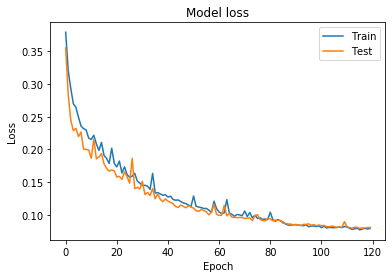

In [32]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


fig.savefig('drive/My Drive/loss.png')


In [0]:
model.load_weights('drive/My Drive/lastrun.h5')


In [0]:
from keras_unet.utils import plot_imgs

y_pred = model.predict(x_val, batch_size = 1, verbose = 1)
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1

plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=24)


In [0]:
from keras import backend as K


get_f1(y_val, y_pred)

In [24]:
test_image_unet_submissionn(imgs_test, size = 400, model = model, filename = 'popopaaa.csv')

50/50 [==============================] - 31s 629ms/step


In [0]:
def test_image_unet_submissionn(imgs_test, size = 400, model = model, filename = 'submission.csv'):


  img1 = []
  img2 = []
  img3 = []
  img4 = []

  shift = 608 - size


  for img in imgs_test:
    img = img[0:size, 0:size, :]
    img1.append(img)

  for img in imgs_test:
    img = img[shift:608, 0:size, :]
    img2.append(img)

  for img in imgs_test:
    img = img[0:size, shift:608, :]
    img3.append(img)

  for img in imgs_test:
    img = img[shift:608, shift:608, :]
    img4.append(img)


  img_pred1 = model.predict(np.asarray(img1), batch_size = 1, verbose = 1)
  img_pred2 = model.predict(np.asarray(img2), batch_size = 1, verbose = 1)
  img_pred3 = model.predict(np.asarray(img3), batch_size = 1, verbose = 1)
  img_pred4 = model.predict(np.asarray(img4), batch_size = 1, verbose = 1)


  img_pred1[img_pred1 <= 0.557] = 0
  img_pred1[img_pred1 > 0.557] = 1

  img_pred2[img_pred2 <= 0.557] = 0
  img_pred2[img_pred2 > 0.557] = 1

  img_pred3[img_pred3 <= 0.557] = 0
  img_pred3[img_pred3 > 0.557] = 1

  img_pred4[img_pred4 <= 0.557] = 0
  img_pred4[img_pred4 > 0.557] = 1

  img1 = np.asarray(img1)
  img2 = np.asarray(img2)
  img3 = np.asarray(img3)
  img4 = np.asarray(img4)

  list_m1 = []
  list_m2 = []
  list_merge = []

  for i in range(50):
    m1 = np.concatenate((img_pred1[i, 0:shift, :, :], img_pred2[i, :, :, :]), axis = 0)
    list_m1.append(m1)
    m2 = np.concatenate((img_pred3[i, 0:shift, :, :], img_pred4[i, :, :, :]), axis = 0)
    list_m2.append(m2)
    
  list_m1 = np.asarray(list_m1)
  list_m2 = np.asarray(list_m2)

  for i in range(50):
    merge = np.concatenate((list_m1[i,:,:,:], list_m2[i, :, (size - shift):size, :]), axis=1)
    list_merge.append(merge)

    
  y_pred = np.asarray(list_merge)

  pred_patch = [img_crop(y_pred[i], 16, 16) for i in range(y_pred.shape[0])]
  pred_patch = np.asarray([pred_patch[i][j] for i in range(len(pred_patch)) for j in range(len(pred_patch[i]))])
  pred_patch = np.asarray([value_to_class(np.mean(pred_patch[i]), foreground_threshold=0.23) for i in range(pred_patch.shape[0])])

  create_submission(pred_patch, filename)



In [109]:

best_score = 0
scores = []

for t in np.linspace(0.40, 0.60, num = 20):
  for f in np.linspace(0.12, 0.38, num = 20):

    y_pred = model.predict(x_val, batch_size = 1, verbose = 1)

    y_pred[y_pred <= t] = 0
    y_pred[y_pred > t] = 1

    pred_patch = [img_crop(y_pred[i], 16, 16) for i in range(y_pred.shape[0])]
    pred_patch = np.asarray([pred_patch[i][j] for i in range(len(pred_patch)) for j in range(len(pred_patch[i]))])
    pred_patch = np.asarray([value_to_class(np.mean(pred_patch[i]), foreground_threshold = f) for i in range(pred_patch.shape[0])])

    val_patch = [img_crop(y_val[i], 16, 16) for i in range(y_val.shape[0])]
    val_patch = np.asarray([val_patch[i][j] for i in range(len(val_patch)) for j in range(len(val_patch[i]))])
    val_patch = np.asarray([value_to_class(np.mean(val_patch[i]), foreground_threshold = f) for i in range(val_patch.shape[0])])


    score = f1_score(val_patch, pred_patch)
    scores.append(score)

    #print(score)
    #print( str(t) + '   nnnnn    ' + str(f))

    if( score > best_score):
      print('Score improve with : foregroud threshold = ' + str(f) + ' threshold = ' + str(t))
      best_score = score


50/50 [==============================] - 6s 129ms/step
Score improve with : foregroud threshold = 0.12 threshold = 0.4
50/50 [==============================] - 6s 129ms/step
Score improve with : foregroud threshold = 0.16105263157894736 threshold = 0.4
50/50 [==============================] - 6s 129ms/step
Score improve with : foregroud threshold = 0.12 threshold = 0.4105263157894737
50/50 [==============================] - 6s 130ms/step
Score improve with : foregroud threshold = 0.12 threshold = 0.4210526315789474
50/50 [==============================] - 7s 130ms/step
Score improve with : foregroud threshold = 0.12 threshold = 0.43157894736842106
50/50 [==============================] - 6s 129ms/step
Score improve with : foregroud threshold = 0.21578947368421053 threshold = 0.43157894736842106
50/50 [==============================] - 7s 130ms/step
Score improve with : foregroud threshold = 0.12 threshold = 0.4421052631578948
50/50 [==============================] - 6s 129ms/step
Score

In [106]:
np.linspace(0.12, 0.38, num = 20)

ValueError: ignored

In [40]:
y_val.shape, x_val.shape, np.asarray(imgs_test).shape

((80, 400, 400, 1), (80, 400, 400, 3), (50, 608, 608, 3))

In [0]:
def patches_prediction(img, model, threshold, foreground, size = 400):


  img_pred = model.predict(np.asarray(img), batch_size = 1, verbose = 1)
  img_pred[img_pred <= threshold] = 0
  img_pred[img_pred > threshold] = 1

  y_pred = np.asarray(img_pred)

  pred_patch = [img_crop(y_pred[i], 16, 16) for i in range(y_pred.shape[0])]
  pred_patch = np.asarray([pred_patch[i][j] for i in range(len(pred_patch)) for j in range(len(pred_patch[i]))])
  pred_patch = np.asarray([value_to_class(np.mean(pred_patch[i]), foreground) for i in range(pred_patch.shape[0])])

  return pred_patch

In [0]:
from sklearn.metrics import f1_score

In [0]:
    def f1_scoreuh(y_true, y_pred):
        # Count positive samples.
        c1 = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
        c2 = np.sum(np.round(np.clip(y_pred, 0, 1)))
        c3 = np.sum(np.round(np.clip(y_true, 0, 1)))

        # If there are no true samples, fix the F1 score at 0.
        if c3 == 0:
            return 0
        # How many selected items are relevant?
        precision = c1 / c2
        # How many relevant items are selected?
        recall = c1 / c3
        # Calculate f1_score
        f1_score = 2 * (precision * recall) / (precision + recall)
        return f1_score, recall, precision

In [0]:
img1 = []
img2 = []
img3 = []
img4 = []

for img in imgs:

  img = img[0:208, 0:208, :]
  img1.append(img)

for img in imgs:
  img = img[192:400, 0:208, :]
  img2.append(img)

for img in imgs:
  img = img[0:208, 192:400, :]
  img3.append(img)

for img in imgs:
  img = img[192:400, 192:400, :]
  img4.append(img)

gt1 = []
gt2 = []
gt3 = []
gt4 = []

for img in gt_imgs:

  img = img[0:208, 0:208]
  gt1.append(img)

for img in gt_imgs:
  img = img[192:400, 0:208]
  gt2.append(img)

for img in gt_imgs:
  img = img[0:208, 192:400]
  gt3.append(img)

for img in gt_imgs:
  img = img[192:400, 192:400]
  gt4.append(img)



In [0]:
img1 = np.asarray(img1)
img2 = np.asarray(img2)
img3 = np.asarray(img3)
img4 = np.asarray(img4)

gt1 = np.asarray(gt1)
gt2 = np.asarray(gt2)
gt3 = np.asarray(gt3)
gt4 = np.asarray(gt4)



In [0]:
imgsnew = np.concatenate((img1, img2, img3, img4), axis = 0)
gtnew = np.concatenate((gt1, gt2, gt3, gt4), axis = 0)

In [11]:
imgsnew.shape, gtnew.shape

((400, 208, 208, 3), (400, 208, 208))

In [0]:
def test_image_unet_submission208(imgs_test, model = model, filename = 'submission.csv'):


  img1 = []
  img2 = []
  img3 = []
  img4 = []
  img5 = []
  img6 = []
  img7 = []
  img8 = []
  img9 = []


  for img in imgs_test:
    img = img[0:208, 0:208, :]
    img1.append(img)

  for img in imgs_test:
    img = img[0:208, 208:416, :]
    img2.append(img)

  for img in imgs_test:
    img = img[0:208, 400:608, :]
    img3.append(img)

  for img in imgs_test:
    img = img[208:416, 0:208, :]
    img4.append(img)

  for img in imgs_test:
    img = img[208:416, 208:416, :]
    img5.append(img)

  for img in imgs_test:
    img = img[208:416, 400:608, :]
    img6.append(img)


  for img in imgs_test:
    img = img[400:608, 0:208, :]
    img7.append(img)

  for img in imgs_test:
    img = img[400:608, 208:416, :]
    img8.append(img)

  for img in imgs_test:
    img = img[400:608, 400:608, :]
    img9.append(img)


  img_pred1 = model.predict(np.asarray(img1), batch_size = 1, verbose = 1)
  img_pred2 = model.predict(np.asarray(img2), batch_size = 1, verbose = 1)
  img_pred3 = model.predict(np.asarray(img3), batch_size = 1, verbose = 1)
  img_pred4 = model.predict(np.asarray(img4), batch_size = 1, verbose = 1)

  img_pred5 = model.predict(np.asarray(img5), batch_size = 1, verbose = 1)
  img_pred6 = model.predict(np.asarray(img6), batch_size = 1, verbose = 1)
  img_pred7 = model.predict(np.asarray(img7), batch_size = 1, verbose = 1)
  img_pred8 = model.predict(np.asarray(img8), batch_size = 1, verbose = 1)
  img_pred9 = model.predict(np.asarray(img9), batch_size = 1, verbose = 1)


  img_pred1[img_pred1 <= 0.5] = 0
  img_pred1[img_pred1 > 0.5] = 1

  img_pred2[img_pred2 <= 0.5] = 0
  img_pred2[img_pred2 > 0.5] = 1

  img_pred3[img_pred3 <= 0.5] = 0
  img_pred3[img_pred3 > 0.5] = 1

  img_pred4[img_pred4 <= 0.5] = 0
  img_pred4[img_pred4 > 0.5] = 1

  img_pred5[img_pred5 <= 0.5] = 0
  img_pred5[img_pred5 > 0.5] = 1

  img_pred6[img_pred6 <= 0.5] = 0
  img_pred6[img_pred6 > 0.5] = 1

  img_pred7[img_pred7 <= 0.5] = 0
  img_pred7[img_pred7 > 0.5] = 1

  img_pred8[img_pred8 <= 0.5] = 0
  img_pred8[img_pred8 > 0.5] = 1

  img_pred9[img_pred9 <= 0.5] = 0
  img_pred9[img_pred9 > 0.5] = 1

  img1 = np.asarray(img1)
  img2 = np.asarray(img2)
  img3 = np.asarray(img3)
  img4 = np.asarray(img4)

  img5 = np.asarray(img5)
  img6 = np.asarray(img6)
  img7 = np.asarray(img7)
  img8 = np.asarray(img8)
  img9 = np.asarray(img9)

  list_m1 = []
  list_m2 = []
  list_m3 = []
  list_merge = []

  for i in range(50):
    m1 = np.concatenate((img_pred1[i, 0:208, :, :], img_pred2[i, 0:208, :, :], img_pred3[i, 16:208, :, :]), axis = 0)
    list_m1.append(m1)
    m2 = np.concatenate((img_pred4[i, 0:208, :, :], img_pred5[i, 0:208, :, :], img_pred6[i, 16:208, :, :]), axis = 0)
    list_m2.append(m2)

    m3 = np.concatenate((img_pred7[i, 0:208, :, :], img_pred8[i, 0:208, :, :], img_pred9[i, 16:208, :, :]), axis = 0)
    list_m3.append(m3)
    
  list_m1 = np.asarray(list_m1)
  list_m2 = np.asarray(list_m2)
  list_m3 = np.asarray(list_m3)
  print(list_m1.shape, list_m2.shape, list_m3.shape)

  for i in range(50):
    merge = np.concatenate((list_m1[i,:,:,:], list_m2[i, :, :, :], list_m3[i,:,16:208,:]), axis = 1)
    list_merge.append(merge)

    
  y_pred = np.asarray(list_merge)
  print(y_pred.shape)

  pred_patch = [img_crop(y_pred[i], 16, 16) for i in range(y_pred.shape[0])]
  pred_patch = np.asarray([pred_patch[i][j] for i in range(len(pred_patch)) for j in range(len(pred_patch[i]))])
  pred_patch = np.asarray([value_to_class(np.mean(pred_patch[i]), foreground_threshold=0.25) for i in range(pred_patch.shape[0])])

  create_submission(pred_patch, filename)



In [42]:
test_image_unet_submission208(imgs_test, model = model, filename = '208asubmission.csv')

50/50 [==============================] - 1s 14ms/step
(50, 608, 208, 1) (50, 608, 208, 1) (50, 608, 208, 1)
(50, 608, 608, 1)
